In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
path = "/content/drive/Shareddrives/covid.eng.pdn.ac.lk drive/COVID-AI (PG)/spatio_temporal/Covid19_DL_Forecasting_Codes"
os.chdir(path)

In [ ]:
!pip install pmdarima
!pip install shap
!pip install gluonts mxnet bayesian-optimization

In [3]:
import sys
import os
import time
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import pandas as pd  # Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
# import gluonts
from math import sqrt

# data manipulation and signal processing
import math
import scipy
from scipy import signal
import scipy.stats as ss

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium

# path = "/con

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics, plot_prediction
from utils.functions import distance, normalize_for_nn, undo_normalization
from utils.data_loader import load_data, per_million, get_daily
from utils.smoothing_functions import O_LPF,NO_LPF,O_NDA,NO_NDA
from utils.data_splitter import split_on_region_dimension, split_on_time_dimension,split_into_pieces_inorder


from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
# from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.trainer import Trainer
# from gluonts.dataset.common import ListDataset
# from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.4.0


# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

Required variables:

*   **region_names** - Names of the unique regions.
*   **confirmed_cases** - 2D array. Each row should corresponds to values in 'region_names'. Each column represents a day. Columns should be in ascending order. (Starting day -> Present)
*   **daily_cases** - confirmed_cases.diff()
*   **population** - Population in 'region'
*   **features** - Features of the regions. Each column is a certain feature.
*   **START_DATE** - Starting date of the data DD/MM/YYYY
*   **n_regions** Number of regions



In [4]:
daily_data = True
DATASET = "Sri Lanka" #"Sri Lanka" "Texas" "USA" "Global"
split_date = '2021-02-01'

d = load_data(DATASET,path="../Datasets")
region_names=d["region_names"] 
confirmed_cases=d["confirmed_cases"] 
daily_cases=d["daily_cases"] 
features=d["features"] 
START_DATE=d["START_DATE"] 
n_regions=d["n_regions"] 
daily_cases[daily_cases<0] = 0
population = features["Population"]
for i in range(len(population)):
    print("{:.2f}%".format(confirmed_cases[i,:].max()/population[i]*100), region_names[i])

days = confirmed_cases.shape[1]

print(f"Total population {population.sum()/1e6:.2f}M, regions:{n_regions}, days:{days}")

daily_filtered = O_LPF(daily_cases, datatype='daily', order=3, R_weight=1.0, EIG_weight=1, corr = True, region_names=region_names)

daily_per_mio_capita = per_million(daily_cases,population)
daily_per_mio_capita_filtered = per_million(daily_filtered,population)


df = pd.DataFrame(daily_cases.T,columns = features.index)
df.index = pd.to_datetime(pd.to_datetime(START_DATE).value + df.index*24*3600*1000000000)


df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('../Datasets/training.csv')
df_test.to_csv('../Datasets/test.csv')

df_training

(25, 126)
['AMPARA', 'ANURADHAPURA', 'BADULLA', 'BATTICOLOA', 'COLOMBO', 'GALLE', 'GAMPAHA', 'HAMBANTOTA', 'JAFFNA', 'KALUTARA', 'KANDY', 'KEGALLE', 'KILINOCHCHI', 'KURUNEGALA', 'MANNAR', 'MONERAGALA', 'MATALE', 'MATARA', 'MULLATIVU', 'NUWARAELIYA', 'POLONNARUWA', 'PUTTALAM', 'RATNAPURA', 'TRINCOMALEE', 'VAVUNIA']
Index(['AMP', 'ANU', 'BAD', 'BAT', 'COL', 'GAL', 'GAM', 'HAM', 'JAF', 'KAL',
       'KAN', 'KEG', 'KIL', 'KUR', 'MAN', 'MON', 'MTL', 'MTR', 'MUL', 'NUW',
       'POL', 'PUT', 'RAT', 'TRI', 'VAN'],
      dtype='object', name='Code')
0.04% AMPARA
0.06% ANURADHAPURA
0.17% BADULLA
0.10% BATTICOLOA
1.21% COLOMBO
0.21% GALLE
0.73% GAMPAHA
0.10% HAMBANTOTA
0.07% JAFFNA
0.51% KALUTARA
0.28% KANDY
0.19% KEGALLE
0.10% KILINOCHCHI
0.15% KURUNEGALA
0.26% MANNAR
0.11% MONERAGALA
0.19% MATALE
0.20% MATARA
0.04% MULLATIVU
0.17% NUWARAELIYA
0.05% POLONNARUWA
0.15% PUTTALAM
0.23% RATNAPURA
0.12% TRINCOMALEE
0.21% VAVUNIA
Total population 21.44M, regions:25, days:126
80 days of training data 


Code,AMP,ANU,BAD,BAT,COL,GAL,GAM,HAM,JAF,KAL,...,MON,MTL,MTR,MUL,NUW,POL,PUT,RAT,TRI,VAN
2020-11-14,0.0,2.0,2.0,6.0,289.0,6.0,22.0,1.0,0.0,8.0,...,2.0,1.0,0.0,0.0,0.0,1.0,1.0,20.0,1.0,0.0
2020-11-15,1.0,1.0,0.0,1.0,248.0,45.0,44.0,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2020-11-16,0.0,39.0,3.0,0.0,557.0,4.0,63.0,1.0,0.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
2020-11-17,3.0,0.0,5.0,5.0,157.0,5.0,56.0,0.0,0.0,79.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-11-18,0.0,3.0,0.0,0.0,260.0,5.0,35.0,0.0,0.0,27.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-28,7.0,2.0,3.0,3.0,310.0,11.0,113.0,13.0,2.0,35.0,...,2.0,3.0,14.0,0.0,1.0,1.0,9.0,1.0,8.0,1.0
2021-01-29,0.0,2.0,19.0,8.0,194.0,6.0,189.0,1.0,3.0,31.0,...,6.0,2.0,34.0,0.0,39.0,1.0,6.0,6.0,1.0,2.0
2021-01-30,14.0,0.0,0.0,0.0,149.0,28.0,126.0,0.0,0.0,48.0,...,1.0,8.0,2.0,0.0,0.0,0.0,18.0,6.0,26.0,0.0
2021-01-31,0.0,0.0,24.0,1.0,210.0,36.0,136.0,8.0,0.0,60.0,...,1.0,12.0,30.0,1.0,27.0,12.0,46.0,56.0,1.0,2.0


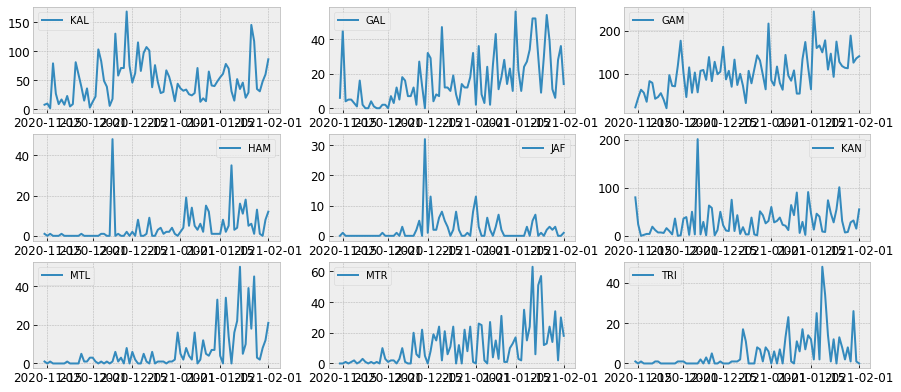

In [5]:
to_plot = ['KAL', 'GAL', 'GAM', 'HAM', 'JAF','KAN','MTL', 'MTR','TRI']
# to_plot = [1,2,3,20]
# to_plot =features.index

plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_training[tp], label=str(tp))
    plt.legend()

It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain. (*harshana I dont understand this statement fully*)

In [6]:
df_test.values.shape

(45, 25)

In [7]:
resultsDict={}
predictionsDict={}
gtDict = {}

#Also add the naive mean average value
mean = df_test.mean()
mean = np.array([mean for _ in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.values, mean)
predictionsDict['Naive mean'] = mean
gtDict['Naive mean'] = df_test.values

resultsDict['Yesterdays value'] = evaluate(df_test.values[:-1,:], df_test.values[1:,:])
predictionsDict['Yesterdays value'] = df_test.values[:-1,:]
gtDict['Yesterdays value'] = df_test.values[1:,:]

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [8]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = [[]]*n_regions
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = SimpleExpSmoothing(temp_train.iloc[:,col])
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['SES'] = evaluate(df_test.values, yhat)
predictionsDict['SES'] = yhat

100%|██████████| 45/45 [00:05<00:00,  8.53it/s]


### Holt Winter’s Exponential Smoothing (HWES)

[HWES](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) or also known as triple exponential smoothing

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = ExponentialSmoothing(temp_train.iloc[:,col])
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['HWES'] = evaluate(df_test.values, yhat)
predictionsDict['HWES'] = yhat

### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = AR(temp_train.iloc[:,col].values)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['AR'] = evaluate(df_test.values, yhat)
predictionsDict['AR'] = yhat

In [ ]:

plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+str(tp))
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='AR predicted '+str(tp))
    plt.legend()

*we can observe a little delay.*

### Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 



In [ ]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = ARMA(temp_train.iloc[:,col], order=(0, 1))
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['MA'] = evaluate(df_test.values, yhat)
predictionsDict['MA'] = yhat


In [ ]:
plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+str(tp))
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='MA predicted '+str(tp))
    plt.legend()

*this is also not fitting ne?*

### Autoregressive Moving Average (ARMA) - Not fitting!

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 



In [ ]:
# # ARMA example
# from statsmodels.tsa.arima_model import ARMA
# from random import random

# # Walk throught the test data, training and predicting 1 day ahead for all the test data
# index = len(df_training)
# yhat = [[]]*df_training.shape[1]
# for t in tqdm(range(len(df_test))):
#     temp_train = df.iloc[:len(df_training)+t,:]
#     for col in range(n_regions):
#         model = ARMA(temp_train.iloc[:,col], order=(1, 1))
        
#         model_fit = model.fit(disp=True)
#         predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
#         yhat[col] = yhat[col] + [predictions]
    
# yhat = np.squeeze(np.array(yhat)).T
# resultsDict['ARMA'] = evaluate(df_test.values, yhat)
# predictionsDict['ARMA'] = yhat

In [ ]:
# plt.figure(figsize=(15, len(to_plot)))
# for i,tp in enumerate(to_plot):
#     plt.subplot(1+len(to_plot)//3,3,i+1)
#     plt.plot(df_test[tp].values, label='Original '+tp)
#     plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='ARMA predicted '+tp)
#     plt.legend()

### Autoregressive integrated moving average (ARIMA) 

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = ARIMA(temp_train.iloc[:,col], order=(1,0, 0))
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['ARIMA'] = evaluate(df_test.values, yhat)
predictionsDict['ARIMA'] = yhat

In [ ]:
plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+tp)
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='ARMA predicted '+tp)
    plt.legend()

#### Auto ARIMA - Not fitting for some

In [ ]:
# #building the model
# autoModels = []
# for col in range(df_training.shape[1]):
#     autoModel = pm.auto_arima(df.iloc[:,col], trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
#     autoModel.fit(df.iloc[:,col])
#     autoModels.append(autoModel)

In [ ]:

# yhat = [[]]*df_training.shape[1]
# for t in tqdm(range(len(df_test))):
#     temp_train = df.iloc[:len(df_training)+t,:]
#     for col in range(n_regions):
#         order = autoModels[col].order
#         print(col)
#         model = ARIMA(temp_train.iloc[:,col], order=order)
#         model_fit = model.fit(disp=False)
#         predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
#         yhat[col] = yhat[col] + [predictions]
    
# yhat = np.squeeze(np.array(yhat)).T
# resultsDict['AutoARIMA'] = evaluate(df_test.values, yhat)
# predictionsDict['AutoARIMA'] = yhat


In [ ]:
# plt.figure(figsize=(15, len(to_plot)))
# for i,tp in enumerate(to_plot):
#     plt.subplot(1+len(to_plot)//3,3,i+1)
#     plt.plot(df_test[tp].values, label='Original '+tp)
#     plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='AutoARMA '+tp)
#     plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        model = SARIMAX(temp_train.iloc[:,col], order=(1,0, 0), seasonal_order=(0, 0, 0, 3))
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['SARIMAX'] = evaluate(df_test.values, yhat)
predictionsDict['SARIMAX'] = yhat


In [ ]:
plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+tp)
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='SARIMAX '+tp)
    plt.legend()

*seems to fit that the predicted signal is only a delay from the original signal*

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [ ]:
#building the model
autoModels = []
for col in range(df_training.shape[1]):
    print(col)
    autoModel = pm.auto_arima(df_training.iloc[:,col], trace=True, error_action='ignore', suppress_warnings=True,seasonal=True, m=6, stepwise=True)
    autoModel.fit(df_training.iloc[:,col])
    autoModels.append(autoModel)

In [ ]:

yhat = [[]]*df_training.shape[1]
for t in tqdm(range(len(df_test))):
    temp_train = df.iloc[:len(df_training)+t,:]
    for col in range(n_regions):
        order = autoModels[col].order
        seasonalOrder = autoModels[col].seasonal_order
        model = SARIMAX(temp_train.iloc[:,col],  order=order, seasonal_order=seasonalOrder)
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
        yhat[col] = yhat[col] + [predictions]
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['AutoSARIMAX'] = evaluate(df_test.values, yhat)
predictionsDict['AutoSARIMAX'] = yhat

In [ ]:
plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+tp)
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='AutoSARIMAX '+tp)
    plt.legend()

### Prophet - Cannot install

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [ ]:
# #Prophet needs some specifics data stuff, coment it here
# prophet_training = df_training.rename(columns={'pollution_today': 'y'})  # old method  
# prophet_training['ds'] = prophet_training.index
# prophet_training.index = pd.RangeIndex(len(prophet_training.index))

# prophet_test = df_test.rename(columns={'pollution_today': 'y'})  # old method  
# prophet_test['ds'] = prophet_test.index
# prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [ ]:
# prophet = Prophet(
#     growth='linear', 
#     seasonality_mode='multiplicative',
#     holidays_prior_scale=20, 
#     daily_seasonality=False, 
#     weekly_seasonality=False, 
#     yearly_seasonality=False
#     ).add_seasonality(
#         name='monthly',
#         period=30.5,
#         fourier_order=55
#     ).add_seasonality(
#         name='daily',
#         period=1,
#         fourier_order=15
#     ).add_seasonality(
#         name='weekly',
#         period=7,
#         fourier_order=25
#     ).add_seasonality(
#         name='yearly',
#         period=365.25,
#         fourier_order=20
#     ).add_seasonality(
#         name='quarterly',
#         period=365.25/4,
#         fourier_order=55
#     ).add_country_holidays(country_name='China')

In [ ]:
# prophet.fit(prophet_training)
# yhat = prophet.predict(prophet_test)
# resultsDict['Prophet univariate'] = evaluate(df_test.pollution_today, yhat.yhat.values)
# predictionsDict['Prophet univariate'] = yhat.yhat.values

In [ ]:
# plt.plot(df_test.pollution_today.values , label='Original')
# plt.plot(yhat.yhat,color='red',label='Prophet univariate')
# plt.legend()

## Multivariate time series forecasting

In [ ]:
# ## ADD time features to our model
# def create_time_features(df,target=None):
#     """
#     Creates time series features from datetime index
#     """
#     df['date'] = df.index
#     df['hour'] = df['date'].dt.hour
#     df['dayofweek'] = df['date'].dt.dayofweek
#     df['quarter'] = df['date'].dt.quarter
#     df['month'] = df['date'].dt.month
#     df['year'] = df['date'].dt.year
#     df['dayofyear'] = df['date'].dt.dayofyear
#     df['sin_day'] = np.sin(df['dayofyear'])
#     df['cos_day'] = np.cos(df['dayofyear'])
#     df['dayofmonth'] = df['date'].dt.day
#     df['weekofyear'] = df['date'].dt.weekofyear
#     X = df.drop(['date'],axis=1)
#     if target:
#         y = df[target]
#         X = X.drop([target],axis=1)
#         return X, y
    
#     return X

In [ ]:
# X_train_df, y_train = create_time_features(df_training, target='pollution_today')
# X_test_df, y_test = create_time_features(df_test, target='pollution_today')
# scaler = StandardScaler() 
# scaler.fit(X_train_df) #No cheating, never scale on the training+test!
# X_train = scaler.transform(X_train_df)  
# X_test = scaler.transform(X_test_df)

# X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
# X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

Required

X = (Days, features)
Y = (Days,)

But we don't have time series features for each districts. Therefore number of features is 1 (covid cases).


### Linear models

#### Bayesian regression

In [10]:
yhat = []
for col in range(n_regions):
    reg = linear_model.BayesianRidge()
    today = df_training.iloc[:-1,col:col+1]
    tomorrow = df_training.iloc[1:,col:col+1]

    reg.fit(today, tomorrow)
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['BayesianRidge'] = evaluate(df_test.values, yhat)
predictionsDict['BayesianRidge'] = yhat

#### Lasso

In [ ]:
yhat = []
for col in range(n_regions):
    reg = linear_model.Lasso(alpha=0.1)
    today = df_training.iloc[:-1,col:col+1]
    tomorrow = df_training.iloc[1:,col:col+1]
    reg.fit(today, tomorrow)
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['Lasso'] = evaluate(df_test.values, yhat)
predictionsDict['Lasso'] = yhat

### Tree models

#### Randomforest

In [ ]:
yhat = []
for col in range(n_regions):
    reg = RandomForestRegressor(max_depth=2, random_state=0)
    reg.fit(df_training.iloc[:-1,col:col+1], df_training.iloc[1:,col:col+1])
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['Randomforest'] = evaluate(df_test.values, yhat)
predictionsDict['Randomforest'] = yhat

#### XGBoost

In [ ]:
yhat = []
for col in range(n_regions):
    reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
    reg.fit(df_training.iloc[:-1,col:col+1], df_training.iloc[1:,col:col+1], verbose=False)
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['XGBoost'] = evaluate(df_test.values, yhat)
predictionsDict['XGBoost'] = yhat


In [ ]:
plt.figure(figsize=(15, len(to_plot)))
for i,tp in enumerate(to_plot):
    plt.subplot(1+len(to_plot)//3,3,i+1)
    plt.plot(df_test[tp].values, label='Original '+tp)
    plt.plot(yhat[:,list(df_test.columns).index(tp)],color='red',label='XGBoost '+tp)
    plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM) 

In [ ]:
yhat = []
for col in range(n_regions):
    reg = lgb.LGBMRegressor()
    reg.fit(df_training.iloc[:-1,col:col+1], df_training.iloc[1:,col:col+1])
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['Lightgbm'] = evaluate(df_test.values, yhat)
predictionsDict['Lightgbm'] = yhat

### Support vector machines

Explain multiple kernels balbla

In [ ]:
yhat = []
for col in range(n_regions):
    reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    reg.fit(df_training.iloc[:-1,col:col+1], df_training.iloc[1:,col:col+1])
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['SVM RBF'] = evaluate(df_test.values, yhat)
predictionsDict['SVM RBF'] = yhat

### Nearest neighbors

In [ ]:
yhat = []
for col in range(n_regions):
    reg = KNeighborsRegressor(n_neighbors=2)
    reg.fit(df_training.iloc[:-1,col:col+1], df_training.iloc[1:,col:col+1])
    yhat.append(reg.predict(df_test.iloc[:,col:col+1]))
    
yhat = np.squeeze(np.array(yhat)).T
resultsDict['Kneighbors'] = evaluate(df_test.values, yhat)
predictionsDict['Kneighbors'] = yhat

### Prophet multivariate

In [ ]:
# prophet = Prophet(
#     growth='linear', 
#     seasonality_mode='multiplicative',
#     daily_seasonality=True, 
#     ).add_country_holidays(country_name='China')


# for col in prophet_training.columns:
#     if col not in ["ds", "y"]:
#         prophet.add_regressor(col)

In [ ]:
# prophet.fit(prophet_training)
# yhat = prophet.predict(prophet_test)
# resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
# predictionsDict['Prophet multivariate'] = yhat.yhat.values

In [ ]:
# plt.plot(df_test.pollution_today.values , label='Original')
# plt.plot(yhat.yhat,color='red',label='Prophet multivariate')
# plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [ ]:
def get_data(filtered, normalize=False):
    if filtered == False:
        x,y= np.copy(daily_cases), np.copy(daily_cases)
    else:
        x,y= np.copy(daily_filtered), np.copy(daily_filtered)
    
    
    x = per_million(x, population)
    y = per_million(y, population)
    if normalize:
        
        x, xs=normalize_for_nn(x, None if type(normalize)==bool else normalize)
        y, xs=normalize_for_nn(y, xs)
        return x.T,y.T,xs
    else:
        return x.T,y.T

In [ ]:
split_date = '2021-02-01'
split_days = (pd.to_datetime(split_date)-pd.to_datetime(START_DATE)).days+2
x_data, y_data, x_data_scalers = get_data(False,normalize=True)
x_dataf, y_dataf, x_data_scalersf = get_data(True, normalize=True)

In [ ]:
def evaluate_model(model, x_data,y_data, scalers):
    WINDOW_LENGTH = model.input.shape[1] 
    PREDICT_STEPS = model.output.shape[1]
    
    tmp = split_on_time_dimension(x_data.T, y_data.T, features, WINDOW_LENGTH, PREDICT_STEPS, 
                                  k_fold=3, test_fold=2, reduce_last_dim=False,
                                  only_train_test=True, debug=False)
    X_train, X_train_feat, Y_train, X_val, X_val_feat, Y_val, X_test, X_test_feat, Y_test = tmp
    
    if model.input.shape[-1]==1:
        y_pred = np.zeros_like(Y_test)
        for i in range(len(region_names)):
            y_pred[:,:,i] = model(X_test[:,:,i:i+1])
    else:
        y_pred = model(X_test).numpy()
    print(X_test.shape,"-->", y_pred.shape)
    # # NOTE:
    # # max value may change with time. then we have to retrain the model!!!!!!
    # # we can have a predefined max value. 1 for major cities and 1 for smaller districts
    x_test = undo_normalization(X_test, scalers)
    y_test = undo_normalization(Y_test, scalers)
    y_pred = undo_normalization(y_pred, scalers)

    return x_test, y_test, y_pred


model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Filtered.h5")
x_test, y_test, y_pred = evaluate_model(model,x_data,y_data, x_data_scalers)

print(np.mean(np.abs(y_test-y_pred)))

x_testf, y_testf, y_predf = evaluate_model(model,x_dataf,y_data, x_data_scalers)

print(np.mean(np.abs(y_testf-y_predf)))


model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Unfiltered.h5")
x_test, y_test, y_pred_unfmodel = evaluate_model(model,x_data,y_data,x_data_scalers)

print(np.mean(np.abs(y_test-y_pred)))

### Load previous models and visualize prediction for each window

In [ ]:
def get_model_predictions(model,x_data,y_data, scalers):
    WINDOW_LENGTH = model.input.shape[1] 
    PREDICT_STEPS = model.output.shape[1]
    
    print(model.input.shape,"-->", model.output.shape)
    
    print(f"Predicting from model. X={x_data.shape} Y={y_data.shape}")
    # CREATING TRAIN-TEST SETS FOR CASES
    x_test, y_test = split_into_pieces_inorder(x_data.T,y_data.T, WINDOW_LENGTH, PREDICT_STEPS, WINDOW_LENGTH+PREDICT_STEPS,
                                               reduce_last_dim=False)
    
    if model.input.shape[-1]==1:
        y_pred = np.zeros_like(y_test)
        for i in range(len(region_names)):
            y_pred[:,:,i] = model(x_test[:,:,i:i+1])
    else:
        y_pred = model(x_test).numpy()
    print(x_test.shape,"-->", y_pred.shape)
    # # NOTE:
    # # max value may change with time. then we have to retrain the model!!!!!!
    # # we can have a predefined max value. 1 for major cities and 1 for smaller districts
    x_test = undo_normalization(x_test, scalers)
    y_test = undo_normalization(y_test, scalers)
    y_pred = undo_normalization(y_pred, scalers)

    return x_test, y_test, y_pred


model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Filtered.h5")
x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
x_test, y_test, y_pred = get_model_predictions(model,x_data,y_data, x_data_scalers)
x_data, y_data, _ = get_data(filtered=True, normalize=x_data_scalers)
x_testf, y_testf, y_predf = get_model_predictions(model,x_data,y_data, x_data_scalers)

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Unfiltered.h5")
x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
x_test, y_test, y_pred_unfmodel = get_model_predictions(model,x_data,y_data,x_data_scalers)

# model =  tf.keras.models.load_model("models/Texas_LSTM_Filtered.h5")
# x_data, y_data, _ = get_data(filtered=False, normalize=True)
# X_test, Y_test, Y_pred_texmodel = get_model_predictions(model,x_data,y_data,x_data_scalers)

Ys = np.stack([y_test, y_testf, y_pred,y_predf,y_pred_unfmodel], 1)
method_list = ['Observations Raw',
               'Observations Filtered',
               'LSTM-F-SL (R-SL)',
               'LSTM-F-SL (F-SL)', 
               'LSTM-R-SL (R-SL)',
#                'Predictions using Raw data (Model trained on Filtered Texas data)',
               ]
styles = {
    'X':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Xf':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Observations Raw':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Observations Filtered':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'LSTM-F-SL (R-SL)':{'Preprocessing':'Raw','Data':'LSTM-F-SL (R-SL)', 'Size':4},
    'LSTM-F-SL (F-SL)':{'Preprocessing':'Filtered','Data':'LSTM-F-SL (F-SL)', 'Size':3},
    'LSTM-R-SL (R-SL)':{'Preprocessing':'Raw','Data':'LSTM-R-SL (R-SL)', 'Size':4},
}
x_data, y_data = get_data(filtered=False, normalize=False)
# region_mask = (np.mean(x_data,0) > 140).astype('int32')
region_mask = (np.arange(n_regions) == 4).astype('int32')

plt.figure(figsize=(20,10))
plot_prediction(x_test,x_testf, Ys, method_list, styles, region_names, region_mask)

plt.savefig(f"images/{DATASET}.eps")
plt.savefig(f"images/{DATASET}.jpg")
plt.show()

   

### Continuous prediction into future from given sequence of data. 

#### Prediction of next day from last 14 days for the test period

In [ ]:
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)

def get_model_predictions(model,x_data,y_data, scalers):
    WINDOW_LENGTH = model.input.shape[1] 
    PREDICT_STEPS = model.output.shape[1]
    print(f"Predicting from model. X={x_data.shape} Y={y_data.shape}")
    X_w,y_w = window_data(x_data,y_data,window=WINDOW_LENGTH)
    
    X_test_w = X_w[split_days-WINDOW_LENGTH-1:-1]
    y_test_w = y_w[split_days-WINDOW_LENGTH-1:-1]
    
    if model.input.shape[-1]==1:
        yhat = []
        for col in range(n_regions):
            yhat.append(model.predict(X_test_w[:,:,col:col+1])[:,0].reshape(1,-1)[0])
        yhat = np.squeeze(np.array(yhat)).T
    else:
        yhat = model.predict(X_test_w[:,:,:])[:,0].reshape(-1,n_regions)
    
    yhat = undo_normalization(yhat, scalers)[0]
    y_test_w = undo_normalization(y_test_w, scalers)[0]
    return X_test_w, y_test_w, yhat

#########################################################################

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Filtered.h5")

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
_, y_test, yhat = get_model_predictions(model,x_data,y_data, x_data_scalers)
resultsDict['LSTM-F-SL (Raw)'] = evaluate(y_test, yhat)
predictionsDict['LSTM-F-SL (Raw)'] = yhat
gtDict['LSTM-F-SL (Raw)'] = y_test

x_dataf, y_dataf, _ = get_data(filtered=True, normalize=x_data_scalers)
_, y_test, yhatf = get_model_predictions(model,x_dataf,y_dataf, x_data_scalers)
resultsDict['LSTM-F-SL (Filtered)'] = evaluate(y_test, yhatf)
predictionsDict['LSTM-F-SL (Filtered)'] = yhatf
gtDict['LSTM-F-SL (Filtered)'] = y_test

#########################################################################

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Unfiltered.h5")

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
_, y_test, y_pred_raw = get_model_predictions(model,x_data,y_data,x_data_scalers)
resultsDict['LSTM-R-SL (Raw)'] = evaluate(y_test, y_pred_raw)
predictionsDict['LSTM-R-SL (Raw)'] = y_pred_raw
gtDict['LSTM-R-SL (Raw)'] = y_test

#########################################################################

# model =  tf.keras.models.load_model("models/Texas_LSTM_Filtered.h5")

# x_dataf, y_dataf, _ = get_data(filtered=True, normalize=x_data_scalers)
# _, y_test, y_pred_rawtex = get_model_predictions(model,x_dataf,y_dataf,x_data_scalers)
# resultsDict['LSTM-F-Texas (Filtered)'] = evaluate(y_test, y_pred_rawtex)
# predictionsDict['LSTM-F-Texas (Filtered)'] = y_pred_rawtex
# gtDict['LSTM-F-Texas (Filtered)'] = y_test

#########################################################################

x_data, y_data = get_data(filtered=False, normalize=False)
x_dataf, y_dataf = get_data(filtered=True, normalize=False)
X = np.expand_dims(x_data[split_days-14:split_days,:],0)
Xf = np.expand_dims(x_dataf[split_days-14:split_days,:],0)
# X = np.expand_dims(x_data[:split_days,:],0)
# Xf = np.expand_dims(x_dataf[:split_days,:],0)
Y = y_data[split_days-1:,:]
Yf = y_dataf[split_days-1:,:]

Ys = [Y,
      y_pred_raw,
      yhatf,
      yhat,
     ]
method_list = ['Observations Raw',
               'Method A',
               'Method B', 
               'Method C',
               ]
styles = {
    'X':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Xf':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Observations Raw':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Method A':{'Preprocessing':'Raw','Data':'Method A', 'Size':4},
    'Method B':{'Preprocessing':'Filtered','Data':'Method B', 'Size':3},
    'Method C':{'Preprocessing':'Raw','Data':'Method C', 'Size':4},
}
          

for i in range(len(Ys)):
    print(method_list[i],Ys[i].shape)
    Ys[i] = np.expand_dims(Ys[i],0)
Ys = np.stack(Ys, 1)

In [ ]:
# region_mask = ((200 > np.mean(x_data,0)) * (np.mean(x_data,0) > 140)).astype('int32')
region_mask = (np.arange(n_regions) == 4).astype('int32')

plt.figure(figsize=(18,9))

plot_prediction(X,Xf, Ys, method_list, styles, region_names, region_mask)

plt.savefig(f"images/{DATASET}_DayByDay.eps")
plt.savefig(f"images/{DATASET}_DayByDay.jpg")
plt.show()

#### Model prediction evolution from given only last 14 days of data.

In [ ]:
def get_model_predictions(model,x_data,y_data, scalers):
    WINDOW_LENGTH = model.input.shape[1] 
    PREDICT_STEPS = model.output.shape[1]
    print(f"Predicting from model. X={x_data.shape} Y={y_data.shape}")
    X_test_w = x_data[split_days-WINDOW_LENGTH-1:split_days-1, :]
    y_test_w = y_data[split_days-1:, :]
    
    
    print(X_test_w.shape, y_test_w.shape)

    
    if model.input.shape[-1]==1:
        X_test_w = np.expand_dims(X_test_w.T,-1) #  shape = regions (samples), window size, 1
        
        yhat = []
        for day in range(split_days-1, x_data.shape[0]):
            y_pred = model.predict(X_test_w)

            X_test_w[:,:-1,:] = X_test_w[:,1:,:] 
            X_test_w[:,-1,:] = y_pred[:, 0:1]

            yhat.append(y_pred[:,0])

    else:
        X_test_w = np.expand_dims(X_test_w,0) #  shape = 1, window size, regions (samples)
        yhat = []
        for day in range(split_days-1, x_data.shape[0]):
            y_pred = model.predict(X_test_w)

            X_test_w[:,:-1,:] = X_test_w[:,1:,:] 
            X_test_w[:,-1,:] = y_pred[:, 0:1,:]

            yhat.append(y_pred[:,0])
            
        
        
        
    
    

    yhat = np.squeeze(np.array(yhat))
    print(yhat.shape,y_test_w.shape)

    yhat = undo_normalization(yhat, scalers)[0]
    y_test_w = undo_normalization(y_test_w, scalers)[0]

    return X_test_w, y_test_w, yhat

#########################################################################

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Filtered.h5")

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
_, y_test, yhat = get_model_predictions(model,x_data,y_data, x_data_scalers)
resultsDict['ELSTM-F-SL (Raw)'] = evaluate(y_test, yhat)
predictionsDict['ELSTM-F-SL (Raw)'] = yhat

x_dataf, y_dataf, _ = get_data(filtered=True, normalize=x_data_scalers)
_, y_test, yhatf = get_model_predictions(model,x_dataf,y_dataf, x_data_scalersf)
resultsDict['ELSTM-F (Filtered)'] = evaluate(y_test, yhatf)
predictionsDict['ELSTM-F-SL (Filtered)'] = yhatf

#########################################################################

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Unfiltered.h5")

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
_, y_test, y_pred_raw = get_model_predictions(model,x_data,y_data,x_data_scalers)
resultsDict['ELSTM-R-SL (Raw)'] = evaluate(y_test, y_pred_raw)
predictionsDict['ELSTM-R-SL (Raw)'] = y_pred_raw

#########################################################################

# model =  tf.keras.models.load_model("models/Texas_LSTM_Filtered.h5")

# x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
# _, y_test, y_pred_rawtex = get_model_predictions(model,x_data,y_data,x_data_scalers)
# resultsDict['ELSTM-F-T (Raw)'] = evaluate(y_test, y_pred_rawtex)
# predictionsDict['ELSTM-F-T (Raw)'] = y_pred_rawtex

#########################################################################

x_data, y_data = get_data(filtered=False, normalize=False)
x_dataf, y_dataf = get_data(filtered=True, normalize=False)
X = np.expand_dims(x_data[split_days-14:split_days,:],0)
Xf = np.expand_dims(x_dataf[split_days-14:split_days,:],0)
# X = np.expand_dims(x_data[:split_days,:],0)
# Xf = np.expand_dims(x_dataf[:split_days,:],0)
Y = y_data[split_days-1:,:]
Yf = y_dataf[split_days-1:,:]

Ys = [Y,
      y_pred_raw,
      yhatf,
      yhat,
     ]
method_list = ['Observations Raw',
               'Method A',
               'Method B', 
               'Method C',
               ]

styles = {
    'X':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Xf':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Observations Raw':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Method A':{'Preprocessing':'Raw','Data':'Method A', 'Size':4},
    'Method B':{'Preprocessing':'Filtered','Data':'Method B', 'Size':3},
    'Method C':{'Preprocessing':'Raw','Data':'Method C', 'Size':4},
}

for i in range(len(Ys)):
    print(method_list[i],Ys[i].shape)
    Ys[i] = np.expand_dims(Ys[i],0)
Ys = np.stack(Ys, 1)


In [ ]:
# region_mask = (np.mean(x_data,0) > 140).astype('int32')
region_mask = (np.arange(n_regions) == 4).astype('int32')

plt.figure(figsize=(18,9))
plot_prediction(X,Xf, Ys, method_list, styles, region_names, region_mask)

plt.savefig(f"images/{DATASET}_Evolution.eps")
plt.savefig(f"images/{DATASET}_Evolution.jpg")
plt.show()

In [ ]:
x = model.input.shape[-2]
r = model.input.shape[-1]
start_seqs = [np.random.random((1,x,r)),
              np.ones((1,x,r))*0,
              np.ones((1,x,r))*0.5,
              np.ones((1,x,r))*1,
              np.arange(x*r).reshape((1,x,r))/30,
              np.sin(np.arange(x)/x*np.pi/2).reshape((1,x,1)).repeat(r,-1)
]

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Filtered.h5")
predictions = []
for start_seq in start_seqs:
    input_seq = np.copy(start_seq)
    print(input_seq.shape)
    predict_seq = [start_seq[0,:,:]]
    for _ in range(50):
        output = model(input_seq, training=False)
        
        input_seq = input_seq[:,output.shape[1]:,:]
        if len(output.shape)==2:
            output = np.expand_dims(output,-1)
        predict_seq.append(output[0])
        input_seq = np.concatenate([input_seq, output],1)
    predictions.append(np.concatenate(predict_seq,0))
    
plt.semilogy(1+np.array(predictions)[:,:30,0].T)
plt.title("Model trained using filtered data")
plt.show()

model =  tf.keras.models.load_model("models/Sri Lanka_LSTM_Unfiltered.h5")
predictions = []
for start_seq in start_seqs:
    input_seq = np.copy(start_seq)
    print(input_seq.shape)
    predict_seq = [start_seq[0,:,:]]
    for _ in range(50):
        output = model(input_seq, training=False)
        
        input_seq = input_seq[:,output.shape[1]:,:]
        if len(output.shape)==2:
            output = np.expand_dims(output,-1)
        predict_seq.append(output[0])
        input_seq = np.concatenate([input_seq, output],1)
    predictions.append(np.concatenate(predict_seq,0))
    
plt.semilogy(1+np.array(predictions)[:,:30,0].T)
plt.title("Model trained using unfiltered data")
plt.show()

#### DeepAR - Pandas version mismatch

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon 

In [ ]:
# features = ['COL']
# # X_train = df_training.values

# # scaler = StandardScaler() 
# # scaler.fit(X_train) #No cheating, never scale on the training+test!
# # df_training[features] = scaler.transform(df_training[features])  
# # df_test[features] = scaler.transform(df_test[features])


# training_data = ListDataset(
#     [{"start": df_training.index[0], "target": df_training.COL,
#       'feat_dynamic_real': [df_training[feature] for feature in features]
#       }],
#     freq="d"
# )
# test_data = ListDataset(
#     [{"start": df_test.index[0], "target": df_test.COL,
#       'feat_dynamic_real': [df_test[feature] for feature in features]
#       }],
#     freq="d"
# )

In [ ]:
# estimator = DeepAREstimator(freq="d",
#                             prediction_length=1
#                             , context_length=30,
#                             trainer=Trainer(epochs=5))

# predictor = estimator.train(training_data=training_data)





# forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=len(df_test))

# forecasts = list(forecast_it)
# tss = list(ts_it)


In [ ]:
# yhat = forecasts[0].samples.reshape(1,-1)[0]
# resultsDict['DeepAR'] = evaluate(y_test,yhat)
# predictionsDict['DeepAR'] = yhat

## Comparison of methods

In [ ]:
metric = 'mae'

arr = []
for method in resultsDict.keys():
    arr.append([])
    for dist in resultsDict[method].keys():
        arr[-1].append(resultsDict[method][dist][metric])

arr = np.array(arr)

In [ ]:
plt.imshow(arr)

In [ ]:
X = np.arange(len(arr[0]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

w = 1/len(arr)
for i in range(len(arr)):
    ax.bar(X + w*i, arr[i,:],  width =w)


In [ ]:
metric = 'mae'

plt.figure(figsize=(6,4))

arr = []
methods = []

methods = list(predictionsDict.keys())
# methods = ['Method A','Method B','Method C']

i=0
# for method in ['LSTM-R-SL (Raw)','LSTM-F-SL (Filtered)','LSTM-F-SL (Raw)']:
for method in predictionsDict.keys():
    if method=="Yesterdays value" :
        continue
    err = predictionsDict[method] - gtDict['LSTM-F-SL (Raw)'] 
    abserr = np.abs(err)
    sqderr = err**2
    mape = (abserr/(gtDict['LSTM-F-SL (Raw)']+predictionsDict[method])*100)
    
    arr.append(abserr)
    methods.append(method)
    
    n, bins, patches = plt.hist(abserr.reshape(-1), 1000, density=True, histtype='step',
                           cumulative=True, label=methods[i])
    i+=1
    
    patches[0].set_xy(patches[0].get_xy()[:-1])
    
    
    print(method)
    print(f'{np.mean(abserr):.2f} {np.mean(sqderr)**0.5:.2f} {np.mean(mape):.2f}')
    
# err = predictionsDict['LSTM-F-SL (Filtered)'] - gtDict['LSTM-F-SL (Raw)'] 
# abserr = np.abs(err)
# sqderr = err**2
# print(np.mean(abserr),np.mean(sqderr)**0.5)

# arr.append(abserr)
# methods.append('ll')
# n, bins, patches =plt.hist(abserr.reshape(-1), 1000, density=True, histtype='step',
#                            cumulative=True, label=methods[-1])
# patches[0].set_xy(patches[0].get_xy()[:-1])
plt.legend(loc='lower right')
plt.xlabel("Absolute error")
plt.ylabel("Cumulative probability density")

In [ ]:
plt.plot(np.mean(arr,-1).T)
plt.legend(predictionsDict.keys())

# Appendix

## Hyperparameter optimization

We have seen models with really low amount of parameters (Auto regression models,Linear models) or with crazy ammount (Trees,Prophet). Some models are more robust to different data types/shapes and dont need any hyperparameter optimization but some other can give you poor results if the parameters are not tunned, we can tune the model parameters to better fit our dataset properties. We can do this manually with pure knowledge about the model but this becames really hard when the model contains a lot of different parameters, this is when hyperparameter optimization comes handy.

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:

* **Grid search** Brute force method to try all different possible combinations of parameters. Will always find the best combination
* **Bayesian processes** "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values. Really nice library for python https://github.com/fmfn/BayesianOptimization, this method will not always find the best combination of parameters

We provide 1 example for each method

### Grid search - SVM

With grid search we can use the handy sklearn implementation

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [ ]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']['rmse']/resultsDict['SVM RBF']['rmse'])
print(f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

### Bayesian processes - Xgboost

In [ ]:
def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'min_samples_leaf': (1,4),
    'min_samples_split': (2,10),
}
 
def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)
    
    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))
 
optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

In [ ]:
params = optimizer.max['params']

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['min_samples_leaf']= int(params['min_samples_leaf'])
params['min_samples_split']= int(params['min_samples_split'])

#Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
tunned_rf.fit(X_train, y_train) # Change verbose to True if you want to see it train

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [ ]:
increase = 1 - (resultsDict['Randomforest tunned']['rmse']/resultsDict['Randomforest']['rmse'])
print(f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

## Ensembling

Ensembling refers to combine multiple models to achieve a better performance, most of the time this only makes sense when models have similar performance but predict values differently so we try to get the best of each model.

We will pick our 3 top performing models and look at the correlation of their residuals, the less correlated the better

In [ ]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.pollution_today.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

We can see how both tree models are a bit similar ~0.87 but quite different from the Deep Learning model with corr ~0.7. In this case it would really make sense to ensemble the methods and see how they behave. The most reasonable combinations to try would be

* XGboost + Tensorflow
* XGBoost + Lightgbm
* Lightgbm + Tensorflow
* XGBoost + Lightgbm + Tensorflow

We will just sum the predictions of each model with similar weights (0.5 if two models, 0.333 if three)

In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.pollution_today.values,predictionsDict['EnsembleXG+TF'])

In [ ]:
import pickle

with open('results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
